In [1]:
from u_cmab import Fourier
from u_cmab import Static_UM
from u_cmab import plot_results
import simulation_code

import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from pylift import TransformedOutcome
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
def restyle(ax, yticks):
    ax.title.set_fontsize(30)
    ax.title.set_text("")
    ax.title.set_fontfamily("sans-serif")
    
    ax.xaxis.label.set_fontsize(30)
    ax.xaxis.label.set_fontfamily("sans-serif")
    ax.xaxis.label.set_text('Fraction of data')

    ax.yaxis.label.set_fontsize(30)
    ax.yaxis.label.set_fontfamily("sans-serif")
    ax.yaxis.label.set_text('Uplift')

    ax.set_yticks(yticks)
    ax.set_xticks([0, .5, 1])

    ax.xaxis.set_tick_params(labelsize=30)
    ax.yaxis.set_tick_params(labelsize=30)

    ax.figure.set_size_inches(13.5, 10.5)

    font = fm.FontProperties(family='sans-serif', size=23)
  
    for l in ax.get_lines():
        if l.get_label() == "Random selection":
            l.set_linewidth(3)
            l.set_dashes((5,5))
            l.set_color('black')
            
    ax.legend(prop=font, loc='upper left')

    return ax

# Collect data
Sudden drift at exp. #10000

In [28]:
sim = simulation_code.Simulation(D=2, std=0.2, drift_rate=3.5, sudden_drift=True, drift_moments=np.array([10000]), base_functions=np.array([simulation_code.Sine_Base(f=4), simulation_code.Sine_Base(f=5)]))

fourier = Fourier(sim, order=5)

epsilon = .1
alpha = .005

_ = fourier.run(epsilon, alpha, .2, 100, lifetime=20000)

# Train static uplift model with `pylift`
- `up_before`: training set `[0:7001]`, test set `[7001:20001]`
- `up_after`: training set `[10000:17001]`, test set `[17001:20001]`
- `up_before`: training set `[0:17001]`, test set `[17001:20001]`

In [4]:
#URF
up_before = TransformedOutcome((
    fourier.RP_run_history.iloc[:,0:4][0:7001], 
    fourier.RP_run_history.iloc[:,0:4][7001:10001]), 
    col_treatment='C', col_outcome='E', 
    stratify=None, 
    sklearn_model=RandomForestRegressor)
up_after = TransformedOutcome((
    fourier.RP_run_history.iloc[:,0:4][10000:17001], 
    fourier.RP_run_history.iloc[:,0:4][17001:20001]), 
    col_treatment='C', col_outcome='E', 
    stratify=None, 
    sklearn_model=RandomForestRegressor)
up_across = TransformedOutcome((
    fourier.RP_run_history.iloc[:,0:4][0:17001], 
    fourier.RP_run_history.iloc[:,0:4][17001:20001]), 
    col_treatment='C', col_outcome='E', 
    stratify=None, 
    sklearn_model=RandomForestRegressor)

In [ ]:
#XGB
up_before_xgb = TransformedOutcome((
    fourier.RP_run_history.iloc[:,0:4][0:7001], 
    fourier.RP_run_history.iloc[:,0:4][7001:10001]), 
    col_treatment='C', col_outcome='E', 
    stratify=None)
up_after_xgb = TransformedOutcome((
    fourier.RP_run_history.iloc[:,0:4][10000:17001], 
    fourier.RP_run_history.iloc[:,0:4][17001:20001]), 
    col_treatment='C', col_outcome='E', 
    stratify=None)
up_across_xgb = TransformedOutcome((
    fourier.RP_run_history.iloc[:,0:4][0:17001], 
    fourier.RP_run_history.iloc[:,0:4][17001:20001]), 
    col_treatment='C', col_outcome='E', 
    stratify=None)

In [6]:
up_before.randomized_search(
    param_distributions={'max_depth': range(2,100), 'min_samples_split': range(2,1000)}, 
    n_iter=50, n_jobs=10)
up_after.randomized_search(
    param_distributions={'max_depth': range(2,100), 'min_samples_split': range(2,1000)}, 
    n_iter=50, n_jobs=10)
up_across.randomized_search(
    param_distributions={'max_depth': range(2,100), 'min_samples_split': range(2,1000)}, 
    n_iter=50, n_jobs=10)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   11.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   12.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    7.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   15.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   20.1s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=10,
          param_distributions={'max_depth': range(2, 100), 'min_samples_split': range(2, 1000)},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,
          return_train_score='warn', scoring=make_scorer(_cgains_score),
          verbose=3)

In [ ]:
up_before_xgb.randomized_search(param_distributions={})
up_after_xgb.randomized_search()
up_across_xgb.randomized_search()

/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] colsample_bytree=0.6660497978526411, gamma=1.3763301413418072, max_depth=4, min_child_weight=292, n_estimators=61, subsample=0.35030090935335934 
[CV]  colsample_bytree=0.6660497978526411, gamma=1.3763301413418072, max_depth=4, min_child_weight=292, n_estimators=61, subsample=0.35030090935335934, score=3.692782664178305e-07, total=   0.1s
[CV] colsample_bytree=0.6660497978526411, gamma=1.3763301413418072, max_depth=4, min_child_weight=292, n_estimators=61, subsample=0.35030090935335934 
[CV]  colsample_bytree=0.6660497978526411, gamma=1.3763301413418072, max_depth=4, min_child_weight=292, n_estimators=61, subsample=0.35030090935335934, score=2.2796193838387014e-06, total=   0.1s
[CV] colsample_bytree=0.6660497978526411, gamma=1.3763301413418072, max_depth=4, min_child_weight=292, n_estimators=61, subsample=0.35030090935335934 
[CV]  colsample_bytree=0.6660497978526411, gamma=1.3763301413418072, max_depth=4, min_child_w

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  colsample_bytree=0.679144526043535, gamma=6.901645920044926, max_depth=18, min_child_weight=79, n_estimators=28, subsample=0.9993487187695687, score=2.2156695985069834e-06, total=   0.1s
[CV] colsample_bytree=0.679144526043535, gamma=6.901645920044926, max_depth=18, min_child_weight=79, n_estimators=28, subsample=0.9993487187695687 
[CV]  colsample_bytree=0.679144526043535, gamma=6.901645920044926, max_depth=18, min_child_weight=79, n_estimators=28, subsample=0.9993487187695687, score=3.799365639731169e-07, total=   0.1s
[CV] colsample_bytree=0.679144526043535, gamma=6.901645920044926, max_depth=18, min_child_weight=79, n_estimators=28, subsample=0.9993487187695687 
[CV]  colsample_bytree=0.679144526043535, gamma=6.901645920044926, max_depth=18, min_child_weight=79, n_estimators=28, subsample=0.9993487187695687, score=3.773746099004561e-07, total=   0.1s
[CV] colsample_bytree=0.9404059281995505, gamma=0.3179454528795378, max_depth=17, min_child_weight=476, n_estimators=243, subsa

[CV]  colsample_bytree=0.8812696604700725, gamma=1.0551799179563615, max_depth=11, min_child_weight=389, n_estimators=282, subsample=0.9948679456225156, score=3.692782664178305e-07, total=   0.6s
[CV] colsample_bytree=0.8812696604700725, gamma=1.0551799179563615, max_depth=11, min_child_weight=389, n_estimators=282, subsample=0.9948679456225156 
[CV]  colsample_bytree=0.8812696604700725, gamma=1.0551799179563615, max_depth=11, min_child_weight=389, n_estimators=282, subsample=0.9948679456225156, score=3.799365639731169e-07, total=   0.6s
[CV] colsample_bytree=0.8812696604700725, gamma=1.0551799179563615, max_depth=11, min_child_weight=389, n_estimators=282, subsample=0.9948679456225156 
[CV]  colsample_bytree=0.8812696604700725, gamma=1.0551799179563615, max_depth=11, min_child_weight=389, n_estimators=282, subsample=0.9948679456225156, score=1.1321238297013681e-06, total=   0.6s
[CV] colsample_bytree=0.7428585209755034, gamma=7.340292662808695, max_depth=13, min_child_weight=449, n_es

[CV]  colsample_bytree=0.653101413739727, gamma=2.734943057119864, max_depth=6, min_child_weight=274, n_estimators=82, subsample=0.7441412402369575, score=-5.348656022732313e-06, total=   0.1s
[CV] colsample_bytree=0.653101413739727, gamma=2.734943057119864, max_depth=6, min_child_weight=274, n_estimators=82, subsample=0.7441412402369575 
[CV]  colsample_bytree=0.653101413739727, gamma=2.734943057119864, max_depth=6, min_child_weight=274, n_estimators=82, subsample=0.7441412402369575, score=7.978667843435454e-06, total=   0.1s
[CV] colsample_bytree=0.653101413739727, gamma=2.734943057119864, max_depth=6, min_child_weight=274, n_estimators=82, subsample=0.7441412402369575 
[CV]  colsample_bytree=0.653101413739727, gamma=2.734943057119864, max_depth=6, min_child_weight=274, n_estimators=82, subsample=0.7441412402369575, score=3.773746099004561e-07, total=   0.1s
[CV] colsample_bytree=0.7272343841389903, gamma=6.443451447079099, max_depth=11, min_child_weight=65, n_estimators=325, subsamp

[CV]  colsample_bytree=0.6916348425416585, gamma=6.368954141839961, max_depth=3, min_child_weight=137, n_estimators=448, subsample=0.8382310212103534, score=3.692782664178305e-07, total=   0.5s
[CV] colsample_bytree=0.6916348425416585, gamma=6.368954141839961, max_depth=3, min_child_weight=137, n_estimators=448, subsample=0.8382310212103534 
[CV]  colsample_bytree=0.6916348425416585, gamma=6.368954141839961, max_depth=3, min_child_weight=137, n_estimators=448, subsample=0.8382310212103534, score=3.799365639731169e-07, total=   0.5s
[CV] colsample_bytree=0.6916348425416585, gamma=6.368954141839961, max_depth=3, min_child_weight=137, n_estimators=448, subsample=0.8382310212103534 
[CV]  colsample_bytree=0.6916348425416585, gamma=6.368954141839961, max_depth=3, min_child_weight=137, n_estimators=448, subsample=0.8382310212103534, score=3.773746099004561e-07, total=   0.5s
[CV] colsample_bytree=0.968375338653187, gamma=4.9223809789557915, max_depth=18, min_child_weight=459, n_estimators=34

[CV]  colsample_bytree=0.6865117134792393, gamma=5.1360722592632735, max_depth=15, min_child_weight=29, n_estimators=96, subsample=0.529281667607836, score=-7.488118431825239e-06, total=   0.3s
[CV] colsample_bytree=0.6865117134792393, gamma=5.1360722592632735, max_depth=15, min_child_weight=29, n_estimators=96, subsample=0.529281667607836 
[CV]  colsample_bytree=0.6865117134792393, gamma=5.1360722592632735, max_depth=15, min_child_weight=29, n_estimators=96, subsample=0.529281667607836, score=-2.201212663679154e-06, total=   0.3s
[CV] colsample_bytree=0.6865117134792393, gamma=5.1360722592632735, max_depth=15, min_child_weight=29, n_estimators=96, subsample=0.529281667607836 
[CV]  colsample_bytree=0.6865117134792393, gamma=5.1360722592632735, max_depth=15, min_child_weight=29, n_estimators=96, subsample=0.529281667607836, score=3.773746099004561e-07, total=   0.3s
[CV] colsample_bytree=0.7211747171888148, gamma=2.1993469114621678, max_depth=14, min_child_weight=48, n_estimators=45, s

[CV]  colsample_bytree=0.9131848914510241, gamma=3.75678639946467, max_depth=8, min_child_weight=22, n_estimators=252, subsample=0.980608648816214, score=-3.565770681821543e-07, total=   0.5s
[CV] colsample_bytree=0.9131848914510241, gamma=3.75678639946467, max_depth=8, min_child_weight=22, n_estimators=252, subsample=0.980608648816214 
[CV]  colsample_bytree=0.9131848914510241, gamma=3.75678639946467, max_depth=8, min_child_weight=22, n_estimators=252, subsample=0.980608648816214, score=3.799365639731169e-07, total=   0.5s
[CV] colsample_bytree=0.9131848914510241, gamma=3.75678639946467, max_depth=8, min_child_weight=22, n_estimators=252, subsample=0.980608648816214 
[CV]  colsample_bytree=0.9131848914510241, gamma=3.75678639946467, max_depth=8, min_child_weight=22, n_estimators=252, subsample=0.980608648816214, score=3.773746099004561e-07, total=   0.5s
[CV] colsample_bytree=0.5997364991897507, gamma=6.086307491590114, max_depth=5, min_child_weight=435, n_estimators=185, subsample=0.

[CV]  colsample_bytree=0.8719012737704137, gamma=9.564413247033984, max_depth=5, min_child_weight=215, n_estimators=100, subsample=0.9912812768691941, score=3.799365639731169e-07, total=   0.1s
[CV] colsample_bytree=0.8719012737704137, gamma=9.564413247033984, max_depth=5, min_child_weight=215, n_estimators=100, subsample=0.9912812768691941 
[CV]  colsample_bytree=0.8719012737704137, gamma=9.564413247033984, max_depth=5, min_child_weight=215, n_estimators=100, subsample=0.9912812768691941, score=2.2642476594027363e-06, total=   0.1s
[CV] colsample_bytree=0.5386980479432862, gamma=1.22206799183588, max_depth=8, min_child_weight=383, n_estimators=387, subsample=0.7853443698473639 
[CV]  colsample_bytree=0.5386980479432862, gamma=1.22206799183588, max_depth=8, min_child_weight=383, n_estimators=387, subsample=0.7853443698473639, score=3.692782664178305e-07, total=   0.6s
[CV] colsample_bytree=0.5386980479432862, gamma=1.22206799183588, max_depth=8, min_child_weight=383, n_estimators=387, 

[CV]  colsample_bytree=0.6234990704132888, gamma=5.970627618739859, max_depth=13, min_child_weight=35, n_estimators=319, subsample=0.5659687550844195, score=3.799365639731169e-07, total=   1.7s
[CV] colsample_bytree=0.6234990704132888, gamma=5.970627618739859, max_depth=13, min_child_weight=35, n_estimators=319, subsample=0.5659687550844195 
[CV]  colsample_bytree=0.6234990704132888, gamma=5.970627618739859, max_depth=13, min_child_weight=35, n_estimators=319, subsample=0.5659687550844195, score=-3.6439494073131694e-06, total=   1.4s
[CV] colsample_bytree=0.8481545149890118, gamma=7.704053343988198, max_depth=9, min_child_weight=322, n_estimators=172, subsample=0.4000018435116685 
[CV]  colsample_bytree=0.8481545149890118, gamma=7.704053343988198, max_depth=9, min_child_weight=322, n_estimators=172, subsample=0.4000018435116685, score=-1.0697312045464629e-06, total=   0.3s
[CV] colsample_bytree=0.8481545149890118, gamma=7.704053343988198, max_depth=9, min_child_weight=322, n_estimators

[CV]  colsample_bytree=0.853805622069644, gamma=1.6678357867290228, max_depth=7, min_child_weight=275, n_estimators=376, subsample=0.5911218608265835, score=-3.66868777279859e-06, total=   0.6s
[CV] colsample_bytree=0.853805622069644, gamma=1.6678357867290228, max_depth=7, min_child_weight=275, n_estimators=376, subsample=0.5911218608265835 
[CV]  colsample_bytree=0.853805622069644, gamma=1.6678357867290228, max_depth=7, min_child_weight=275, n_estimators=376, subsample=0.5911218608265835, score=3.773746099004561e-07, total=   0.6s
[CV] colsample_bytree=0.689181578922399, gamma=7.11689438669578, max_depth=20, min_child_weight=199, n_estimators=85, subsample=0.49727135372043907 
[CV]  colsample_bytree=0.689181578922399, gamma=7.11689438669578, max_depth=20, min_child_weight=199, n_estimators=85, subsample=0.49727135372043907, score=-1.0697312045464629e-06, total=   0.1s
[CV] colsample_bytree=0.689181578922399, gamma=7.11689438669578, max_depth=20, min_child_weight=199, n_estimators=85, 

[CV]  colsample_bytree=0.7786817523185761, gamma=4.934302571286818, max_depth=6, min_child_weight=163, n_estimators=30, subsample=0.6897667407192567, score=1.1398096919193507e-06, total=   0.1s
[CV] colsample_bytree=0.7786817523185761, gamma=4.934302571286818, max_depth=6, min_child_weight=163, n_estimators=30, subsample=0.6897667407192567 
[CV]  colsample_bytree=0.7786817523185761, gamma=4.934302571286818, max_depth=6, min_child_weight=163, n_estimators=30, subsample=0.6897667407192567, score=1.1321238297013681e-06, total=   0.1s
[CV] colsample_bytree=0.6578061396410565, gamma=1.4864211523911564, max_depth=5, min_child_weight=432, n_estimators=496, subsample=0.8630657524389693 
[CV]  colsample_bytree=0.6578061396410565, gamma=1.4864211523911564, max_depth=5, min_child_weight=432, n_estimators=496, subsample=0.8630657524389693, score=3.692782664178305e-07, total=   0.7s
[CV] colsample_bytree=0.6578061396410565, gamma=1.4864211523911564, max_depth=5, min_child_weight=432, n_estimators=4

[CV]  colsample_bytree=0.5201301946468724, gamma=2.0996057272042403, max_depth=3, min_child_weight=293, n_estimators=193, subsample=0.8634563303482925, score=2.2796193838387014e-06, total=   0.2s
[CV] colsample_bytree=0.5201301946468724, gamma=2.0996057272042403, max_depth=3, min_child_weight=293, n_estimators=193, subsample=0.8634563303482925 
[CV]  colsample_bytree=0.5201301946468724, gamma=2.0996057272042403, max_depth=3, min_child_weight=293, n_estimators=193, subsample=0.8634563303482925, score=2.2642476594027363e-06, total=   0.2s
[CV] colsample_bytree=0.6502250796532799, gamma=2.9901559230330568, max_depth=13, min_child_weight=339, n_estimators=206, subsample=0.42195578815454415 
[CV]  colsample_bytree=0.6502250796532799, gamma=2.9901559230330568, max_depth=13, min_child_weight=339, n_estimators=206, subsample=0.42195578815454415, score=-3.565770681821543e-07, total=   0.2s
[CV] colsample_bytree=0.6502250796532799, gamma=2.9901559230330568, max_depth=13, min_child_weight=339, n_

[CV]  colsample_bytree=0.9642446785141707, gamma=8.142585110157182, max_depth=9, min_child_weight=129, n_estimators=120, subsample=0.7300500198042472, score=2.2796193838387014e-06, total=   0.2s
[CV] colsample_bytree=0.9642446785141707, gamma=8.142585110157182, max_depth=9, min_child_weight=129, n_estimators=120, subsample=0.7300500198042472 
[CV]  colsample_bytree=0.9642446785141707, gamma=8.142585110157182, max_depth=9, min_child_weight=129, n_estimators=120, subsample=0.7300500198042472, score=3.773746099004561e-07, total=   0.2s
[CV] colsample_bytree=0.5214253027035187, gamma=9.845223083829799, max_depth=7, min_child_weight=233, n_estimators=329, subsample=0.7057678703911623 
[CV]  colsample_bytree=0.5214253027035187, gamma=9.845223083829799, max_depth=7, min_child_weight=233, n_estimators=329, subsample=0.7057678703911623, score=-1.0697312045464629e-06, total=   0.5s
[CV] colsample_bytree=0.5214253027035187, gamma=9.845223083829799, max_depth=7, min_child_weight=233, n_estimators=

[CV]  colsample_bytree=0.8018477334212619, gamma=1.7172522742717478, max_depth=16, min_child_weight=361, n_estimators=187, subsample=0.4239358027906532, score=1.1398096919193507e-06, total=   0.3s
[CV] colsample_bytree=0.8018477334212619, gamma=1.7172522742717478, max_depth=16, min_child_weight=361, n_estimators=187, subsample=0.4239358027906532 
[CV]  colsample_bytree=0.8018477334212619, gamma=1.7172522742717478, max_depth=16, min_child_weight=361, n_estimators=187, subsample=0.4239358027906532, score=-3.6439494073131694e-07, total=   0.2s
[CV] colsample_bytree=0.681171981432978, gamma=4.097622943409096, max_depth=16, min_child_weight=34, n_estimators=207, subsample=0.6276725529986448 
[CV]  colsample_bytree=0.681171981432978, gamma=4.097622943409096, max_depth=16, min_child_weight=34, n_estimators=207, subsample=0.6276725529986448, score=-2.1394624090929254e-06, total=   0.8s
[CV] colsample_bytree=0.681171981432978, gamma=4.097622943409096, max_depth=16, min_child_weight=34, n_estima

[CV]  colsample_bytree=0.5034429980105759, gamma=5.233441554169387, max_depth=20, min_child_weight=357, n_estimators=33, subsample=0.4382621147184554, score=3.799365639731169e-06, total=   0.1s
[CV] colsample_bytree=0.5034429980105759, gamma=5.233441554169387, max_depth=20, min_child_weight=357, n_estimators=33, subsample=0.4382621147184554 
[CV]  colsample_bytree=0.5034429980105759, gamma=5.233441554169387, max_depth=20, min_child_weight=357, n_estimators=33, subsample=0.4382621147184554, score=3.773746099004561e-07, total=   0.1s
[CV] colsample_bytree=0.8949596482476574, gamma=1.722645850400245, max_depth=15, min_child_weight=405, n_estimators=340, subsample=0.7257387990056818 
[CV]  colsample_bytree=0.8949596482476574, gamma=1.722645850400245, max_depth=15, min_child_weight=405, n_estimators=340, subsample=0.7257387990056818, score=-3.565770681821543e-07, total=   0.6s
[CV] colsample_bytree=0.8949596482476574, gamma=1.722645850400245, max_depth=15, min_child_weight=405, n_estimators

[CV]  colsample_bytree=0.6976108658565079, gamma=1.101535600498913, max_depth=12, min_child_weight=246, n_estimators=71, subsample=0.4190078496898112, score=5.699048459596753e-06, total=   0.1s
[CV] colsample_bytree=0.6976108658565079, gamma=1.101535600498913, max_depth=12, min_child_weight=246, n_estimators=71, subsample=0.4190078496898112 
[CV]  colsample_bytree=0.6976108658565079, gamma=1.101535600498913, max_depth=12, min_child_weight=246, n_estimators=71, subsample=0.4190078496898112, score=-3.6439494073131694e-07, total=   0.1s
[CV] colsample_bytree=0.7263548199040565, gamma=3.0675076143436533, max_depth=15, min_child_weight=94, n_estimators=40, subsample=0.8490342020736716 
[CV]  colsample_bytree=0.7263548199040565, gamma=3.0675076143436533, max_depth=15, min_child_weight=94, n_estimators=40, subsample=0.8490342020736716, score=-1.0697312045464629e-06, total=   0.1s
[CV] colsample_bytree=0.7263548199040565, gamma=3.0675076143436533, max_depth=15, min_child_weight=94, n_estimator

[CV]  colsample_bytree=0.857534273314687, gamma=6.4090184121138325, max_depth=3, min_child_weight=319, n_estimators=337, subsample=0.7753821947120583, score=3.799365639731169e-07, total=   0.4s
[CV] colsample_bytree=0.857534273314687, gamma=6.4090184121138325, max_depth=3, min_child_weight=319, n_estimators=337, subsample=0.7753821947120583 
[CV]  colsample_bytree=0.857534273314687, gamma=6.4090184121138325, max_depth=3, min_child_weight=319, n_estimators=337, subsample=0.7753821947120583, score=3.773746099004561e-07, total=   0.4s
[CV] colsample_bytree=0.9946643908763327, gamma=3.050142979931919, max_depth=7, min_child_weight=236, n_estimators=193, subsample=0.47198333540364173 
[CV]  colsample_bytree=0.9946643908763327, gamma=3.050142979931919, max_depth=7, min_child_weight=236, n_estimators=193, subsample=0.47198333540364173, score=1.1078347992534917e-06, total=   0.4s
[CV] colsample_bytree=0.9946643908763327, gamma=3.050142979931919, max_depth=7, min_child_weight=236, n_estimators=

[CV]  colsample_bytree=0.6884904929349623, gamma=4.00653080218805, max_depth=18, min_child_weight=65, n_estimators=103, subsample=0.6756913636847317, score=-3.66868777279859e-07, total=   0.5s
[CV] colsample_bytree=0.6884904929349623, gamma=4.00653080218805, max_depth=18, min_child_weight=65, n_estimators=103, subsample=0.6756913636847317 
[CV]  colsample_bytree=0.6884904929349623, gamma=4.00653080218805, max_depth=18, min_child_weight=65, n_estimators=103, subsample=0.6756913636847317, score=3.773746099004561e-07, total=   0.5s
[CV] colsample_bytree=0.5771922258786377, gamma=2.43368617703421, max_depth=9, min_child_weight=484, n_estimators=250, subsample=0.8237916593873511 
[CV]  colsample_bytree=0.5771922258786377, gamma=2.43368617703421, max_depth=9, min_child_weight=484, n_estimators=250, subsample=0.8237916593873511, score=-3.565770681821543e-07, total=   0.6s
[CV] colsample_bytree=0.5771922258786377, gamma=2.43368617703421, max_depth=9, min_child_weight=484, n_estimators=250, sub

[CV]  colsample_bytree=0.951570875423509, gamma=8.968565441344337, max_depth=13, min_child_weight=262, n_estimators=216, subsample=0.8010809032884012, score=3.799365639731169e-07, total=   0.5s
[CV] colsample_bytree=0.951570875423509, gamma=8.968565441344337, max_depth=13, min_child_weight=262, n_estimators=216, subsample=0.8010809032884012 
[CV]  colsample_bytree=0.951570875423509, gamma=8.968565441344337, max_depth=13, min_child_weight=262, n_estimators=216, subsample=0.8010809032884012, score=1.1321238297013681e-06, total=   0.5s
[CV] colsample_bytree=0.6561220227298565, gamma=5.2087175942300945, max_depth=15, min_child_weight=421, n_estimators=158, subsample=0.9577869391686682 
[CV]  colsample_bytree=0.6561220227298565, gamma=5.2087175942300945, max_depth=15, min_child_weight=421, n_estimators=158, subsample=0.9577869391686682, score=3.692782664178305e-07, total=   0.4s
[CV] colsample_bytree=0.6561220227298565, gamma=5.2087175942300945, max_depth=15, min_child_weight=421, n_estimat

[CV]  colsample_bytree=0.5090743293169513, gamma=9.664099426171012, max_depth=10, min_child_weight=269, n_estimators=199, subsample=0.8464934106729272, score=-3.66868777279859e-07, total=   0.3s
[CV] colsample_bytree=0.5090743293169513, gamma=9.664099426171012, max_depth=10, min_child_weight=269, n_estimators=199, subsample=0.8464934106729272 
[CV]  colsample_bytree=0.5090743293169513, gamma=9.664099426171012, max_depth=10, min_child_weight=269, n_estimators=199, subsample=0.8464934106729272, score=3.773746099004561e-07, total=   0.4s
[CV] colsample_bytree=0.5491919817513486, gamma=8.284344692690274, max_depth=4, min_child_weight=284, n_estimators=373, subsample=0.5463166676383201 
[CV]  colsample_bytree=0.5491919817513486, gamma=8.284344692690274, max_depth=4, min_child_weight=284, n_estimators=373, subsample=0.5463166676383201, score=-1.0697312045464629e-06, total=   0.7s
[CV] colsample_bytree=0.5491919817513486, gamma=8.284344692690274, max_depth=4, min_child_weight=284, n_estimator

[CV]  colsample_bytree=0.9276301558512461, gamma=4.378088417471631, max_depth=19, min_child_weight=409, n_estimators=341, subsample=0.7204008525465406, score=1.1398096919193507e-06, total=   0.7s
[CV] colsample_bytree=0.9276301558512461, gamma=4.378088417471631, max_depth=19, min_child_weight=409, n_estimators=341, subsample=0.7204008525465406 
[CV]  colsample_bytree=0.9276301558512461, gamma=4.378088417471631, max_depth=19, min_child_weight=409, n_estimators=341, subsample=0.7204008525465406, score=1.1321238297013681e-06, total=   0.6s
[CV] colsample_bytree=0.6326148867544196, gamma=8.904775095267361, max_depth=20, min_child_weight=284, n_estimators=222, subsample=0.6078080924003815 
[CV]  colsample_bytree=0.6326148867544196, gamma=8.904775095267361, max_depth=20, min_child_weight=284, n_estimators=222, subsample=0.6078080924003815, score=3.692782664178305e-07, total=   0.5s
[CV] colsample_bytree=0.6326148867544196, gamma=8.904775095267361, max_depth=20, min_child_weight=284, n_estima

[CV]  colsample_bytree=0.6120629900992576, gamma=8.276416944714162, max_depth=16, min_child_weight=129, n_estimators=65, subsample=0.9634900083164637, score=3.799365639731169e-07, total=   0.4s
[CV] colsample_bytree=0.6120629900992576, gamma=8.276416944714162, max_depth=16, min_child_weight=129, n_estimators=65, subsample=0.9634900083164637 
[CV]  colsample_bytree=0.6120629900992576, gamma=8.276416944714162, max_depth=16, min_child_weight=129, n_estimators=65, subsample=0.9634900083164637, score=3.7737460990045613e-06, total=   0.2s
[CV] colsample_bytree=0.5601160589161931, gamma=6.542377684687749, max_depth=11, min_child_weight=382, n_estimators=420, subsample=0.7000211046968873 
[CV]  colsample_bytree=0.5601160589161931, gamma=6.542377684687749, max_depth=11, min_child_weight=382, n_estimators=420, subsample=0.7000211046968873, score=3.692782664178305e-07, total=   0.9s
[CV] colsample_bytree=0.5601160589161931, gamma=6.542377684687749, max_depth=11, min_child_weight=382, n_estimators

[CV]  colsample_bytree=0.7046979523558056, gamma=0.5561309702317452, max_depth=5, min_child_weight=36, n_estimators=53, subsample=0.9116321027673362, score=3.799365639731169e-07, total=   0.1s
[CV] colsample_bytree=0.7046979523558056, gamma=0.5561309702317452, max_depth=5, min_child_weight=36, n_estimators=53, subsample=0.9116321027673362 
[CV]  colsample_bytree=0.7046979523558056, gamma=0.5561309702317452, max_depth=5, min_child_weight=36, n_estimators=53, subsample=0.9116321027673362, score=3.773746099004561e-07, total=   0.1s
[CV] colsample_bytree=0.9250425318641035, gamma=1.0955225374345712, max_depth=5, min_child_weight=71, n_estimators=313, subsample=0.5083589094684317 
[CV]  colsample_bytree=0.9250425318641035, gamma=1.0955225374345712, max_depth=5, min_child_weight=71, n_estimators=313, subsample=0.5083589094684317, score=3.692782664178305e-07, total=   0.6s
[CV] colsample_bytree=0.9250425318641035, gamma=1.0955225374345712, max_depth=5, min_child_weight=71, n_estimators=313, s

[CV] colsample_bytree=0.5517952053100779, gamma=8.953593241078776, max_depth=8, min_child_weight=231, n_estimators=84, subsample=0.8112236682134466 
[CV]  colsample_bytree=0.5517952053100779, gamma=8.953593241078776, max_depth=8, min_child_weight=231, n_estimators=84, subsample=0.8112236682134466, score=-3.6439494073131694e-07, total=   0.2s
[CV] colsample_bytree=0.9445082476951266, gamma=4.191916348729387, max_depth=10, min_child_weight=44, n_estimators=273, subsample=0.39718115451217134 
[CV]  colsample_bytree=0.9445082476951266, gamma=4.191916348729387, max_depth=10, min_child_weight=44, n_estimators=273, subsample=0.39718115451217134, score=3.692782664178305e-07, total=   0.7s
[CV] colsample_bytree=0.9445082476951266, gamma=4.191916348729387, max_depth=10, min_child_weight=44, n_estimators=273, subsample=0.39718115451217134 
[CV]  colsample_bytree=0.9445082476951266, gamma=4.191916348729387, max_depth=10, min_child_weight=44, n_estimators=273, subsample=0.39718115451217134, score=3

[CV]  colsample_bytree=0.9936045994028322, gamma=1.0417530059659819, max_depth=18, min_child_weight=441, n_estimators=190, subsample=0.5837122051228867, score=1.1321238297013681e-06, total=   0.3s
[CV] colsample_bytree=0.8061163549835555, gamma=3.1386726393255016, max_depth=16, min_child_weight=67, n_estimators=473, subsample=0.777329491579895 
[CV]  colsample_bytree=0.8061163549835555, gamma=3.1386726393255016, max_depth=16, min_child_weight=67, n_estimators=473, subsample=0.777329491579895, score=-1.0697312045464629e-06, total=   1.7s
[CV] colsample_bytree=0.8061163549835555, gamma=3.1386726393255016, max_depth=16, min_child_weight=67, n_estimators=473, subsample=0.777329491579895 
[CV]  colsample_bytree=0.8061163549835555, gamma=3.1386726393255016, max_depth=16, min_child_weight=67, n_estimators=473, subsample=0.777329491579895, score=-3.66868777279859e-07, total=   1.6s
[CV] colsample_bytree=0.8061163549835555, gamma=3.1386726393255016, max_depth=16, min_child_weight=67, n_estimato

[CV]  colsample_bytree=0.5655101792545663, gamma=5.166082082975104, max_depth=9, min_child_weight=496, n_estimators=439, subsample=0.5660936219994709, score=-3.6439494073131694e-07, total=   0.6s
[CV] colsample_bytree=0.9260596927776159, gamma=1.6909901063558108, max_depth=2, min_child_weight=341, n_estimators=388, subsample=0.5599606269826173 
[CV]  colsample_bytree=0.9260596927776159, gamma=1.6909901063558108, max_depth=2, min_child_weight=341, n_estimators=388, subsample=0.5599606269826173, score=-2.1394624090929254e-06, total=   0.4s
[CV] colsample_bytree=0.9260596927776159, gamma=1.6909901063558108, max_depth=2, min_child_weight=341, n_estimators=388, subsample=0.5599606269826173 
[CV]  colsample_bytree=0.9260596927776159, gamma=1.6909901063558108, max_depth=2, min_child_weight=341, n_estimators=388, subsample=0.5599606269826173, score=3.799365639731169e-07, total=   0.4s
[CV] colsample_bytree=0.9260596927776159, gamma=1.6909901063558108, max_depth=2, min_child_weight=341, n_estim

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  5.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.8889309993382775, gamma=7.286313546537536, max_depth=2, min_child_weight=227, n_estimators=336, subsample=0.9719437347729891, score=0.09544147644601307, total=   0.7s
[CV] colsample_bytree=0.8889309993382775, gamma=7.286313546537536, max_depth=2, min_child_weight=227, n_estimators=336, subsample=0.9719437347729891 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  colsample_bytree=0.8889309993382775, gamma=7.286313546537536, max_depth=2, min_child_weight=227, n_estimators=336, subsample=0.9719437347729891, score=0.08224715351429764, total=   0.5s
[CV] colsample_bytree=0.8889309993382775, gamma=7.286313546537536, max_depth=2, min_child_weight=227, n_estimators=336, subsample=0.9719437347729891 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  colsample_bytree=0.8889309993382775, gamma=7.286313546537536, max_depth=2, min_child_weight=227, n_estimators=336, subsample=0.9719437347729891, score=0.0872112284341419, total=   0.4s
[CV] colsample_bytree=0.6350653751993536, gamma=6.123588541492213, max_depth=9, min_child_weight=422, n_estimators=329, subsample=0.7831669569289779 
[CV]  colsample_bytree=0.6350653751993536, gamma=6.123588541492213, max_depth=9, min_child_weight=422, n_estimators=329, subsample=0.7831669569289779, score=0.08472877045566965, total=   0.6s
[CV] colsample_bytree=0.6350653751993536, gamma=6.123588541492213, max_depth=9, min_child_weight=422, n_estimators=329, subsample=0.7831669569289779 
[CV]  colsample_bytree=0.6350653751993536, gamma=6.123588541492213, max_depth=9, min_child_weight=422, n_estimators=329, subsample=0.7831669569289779, score=0.08173651412464379, total=   0.6s
[CV] colsample_bytree=0.6350653751993536, gamma=6.123588541492213, max_depth=9, min_child_weight=422, n_estimators=329, subsa

[CV]  colsample_bytree=0.681260100817542, gamma=1.0038270486327516, max_depth=2, min_child_weight=195, n_estimators=269, subsample=0.7224655529323252, score=0.07673143431415057, total=   0.3s
[CV] colsample_bytree=0.5659437105833911, gamma=2.7961735262759713, max_depth=14, min_child_weight=486, n_estimators=143, subsample=0.5649450492646375 
[CV]  colsample_bytree=0.5659437105833911, gamma=2.7961735262759713, max_depth=14, min_child_weight=486, n_estimators=143, subsample=0.5649450492646375, score=0.09022193830631121, total=   0.2s
[CV] colsample_bytree=0.5659437105833911, gamma=2.7961735262759713, max_depth=14, min_child_weight=486, n_estimators=143, subsample=0.5649450492646375 
[CV]  colsample_bytree=0.5659437105833911, gamma=2.7961735262759713, max_depth=14, min_child_weight=486, n_estimators=143, subsample=0.5649450492646375, score=0.08629880061114809, total=   0.2s
[CV] colsample_bytree=0.5659437105833911, gamma=2.7961735262759713, max_depth=14, min_child_weight=486, n_estimators

[CV]  colsample_bytree=0.7665191182723027, gamma=5.128893828944405, max_depth=17, min_child_weight=3, n_estimators=245, subsample=0.8344474648776945, score=0.04073617674851765, total=   2.0s
[CV] colsample_bytree=0.9608138125907766, gamma=9.083477789741345, max_depth=6, min_child_weight=376, n_estimators=231, subsample=0.5199279448183186 
[CV]  colsample_bytree=0.9608138125907766, gamma=9.083477789741345, max_depth=6, min_child_weight=376, n_estimators=231, subsample=0.5199279448183186, score=0.09116291390270075, total=   0.4s
[CV] colsample_bytree=0.9608138125907766, gamma=9.083477789741345, max_depth=6, min_child_weight=376, n_estimators=231, subsample=0.5199279448183186 
[CV]  colsample_bytree=0.9608138125907766, gamma=9.083477789741345, max_depth=6, min_child_weight=376, n_estimators=231, subsample=0.5199279448183186, score=0.08822700836313528, total=   0.3s
[CV] colsample_bytree=0.9608138125907766, gamma=9.083477789741345, max_depth=6, min_child_weight=376, n_estimators=231, subsa

[CV]  colsample_bytree=0.5278814547158039, gamma=4.095932579525807, max_depth=18, min_child_weight=227, n_estimators=94, subsample=0.36488002790344976, score=0.08069754707732675, total=   0.2s
[CV] colsample_bytree=0.5278814547158039, gamma=4.095932579525807, max_depth=18, min_child_weight=227, n_estimators=94, subsample=0.36488002790344976 
[CV]  colsample_bytree=0.5278814547158039, gamma=4.095932579525807, max_depth=18, min_child_weight=227, n_estimators=94, subsample=0.36488002790344976, score=0.0789747947921761, total=   0.2s
[CV] colsample_bytree=0.5949193259395331, gamma=4.210896983293892, max_depth=9, min_child_weight=410, n_estimators=119, subsample=0.9991052132021632 
[CV]  colsample_bytree=0.5949193259395331, gamma=4.210896983293892, max_depth=9, min_child_weight=410, n_estimators=119, subsample=0.9991052132021632, score=0.0952734909555542, total=   0.2s
[CV] colsample_bytree=0.5949193259395331, gamma=4.210896983293892, max_depth=9, min_child_weight=410, n_estimators=119, sub

[CV]  colsample_bytree=0.5771101984594977, gamma=3.244167407899232, max_depth=20, min_child_weight=239, n_estimators=351, subsample=0.5089004213059645, score=0.06238617710352221, total=   0.6s
[CV] colsample_bytree=0.5771101984594977, gamma=3.244167407899232, max_depth=20, min_child_weight=239, n_estimators=351, subsample=0.5089004213059645 
[CV]  colsample_bytree=0.5771101984594977, gamma=3.244167407899232, max_depth=20, min_child_weight=239, n_estimators=351, subsample=0.5089004213059645, score=0.07429141778309227, total=   0.6s
[CV] colsample_bytree=0.5278707473378166, gamma=5.969192693031303, max_depth=17, min_child_weight=7, n_estimators=320, subsample=0.776309972714174 
[CV]  colsample_bytree=0.5278707473378166, gamma=5.969192693031303, max_depth=17, min_child_weight=7, n_estimators=320, subsample=0.776309972714174, score=0.030434232912370622, total=   1.2s
[CV] colsample_bytree=0.5278707473378166, gamma=5.969192693031303, max_depth=17, min_child_weight=7, n_estimators=320, subsa

[CV]  colsample_bytree=0.6854649672649162, gamma=3.91322673181405, max_depth=10, min_child_weight=15, n_estimators=50, subsample=0.46345588535781435, score=0.041765695500366684, total=   0.1s
[CV] colsample_bytree=0.5610904118420972, gamma=3.25463852047859, max_depth=11, min_child_weight=483, n_estimators=395, subsample=0.5194588159569566 
[CV]  colsample_bytree=0.5610904118420972, gamma=3.25463852047859, max_depth=11, min_child_weight=483, n_estimators=395, subsample=0.5194588159569566, score=0.08647750093769628, total=   0.6s
[CV] colsample_bytree=0.5610904118420972, gamma=3.25463852047859, max_depth=11, min_child_weight=483, n_estimators=395, subsample=0.5194588159569566 
[CV]  colsample_bytree=0.5610904118420972, gamma=3.25463852047859, max_depth=11, min_child_weight=483, n_estimators=395, subsample=0.5194588159569566, score=0.08045182650016812, total=   0.5s
[CV] colsample_bytree=0.5610904118420972, gamma=3.25463852047859, max_depth=11, min_child_weight=483, n_estimators=395, subs

[CV]  colsample_bytree=0.7865490487196956, gamma=3.567294317638204, max_depth=16, min_child_weight=242, n_estimators=435, subsample=0.8318569903981277, score=0.06622033786491327, total=   0.8s
[CV] colsample_bytree=0.7865490487196956, gamma=3.567294317638204, max_depth=16, min_child_weight=242, n_estimators=435, subsample=0.8318569903981277 
[CV]  colsample_bytree=0.7865490487196956, gamma=3.567294317638204, max_depth=16, min_child_weight=242, n_estimators=435, subsample=0.8318569903981277, score=0.05311277687012704, total=   0.9s
[CV] colsample_bytree=0.7865490487196956, gamma=3.567294317638204, max_depth=16, min_child_weight=242, n_estimators=435, subsample=0.8318569903981277 
[CV]  colsample_bytree=0.7865490487196956, gamma=3.567294317638204, max_depth=16, min_child_weight=242, n_estimators=435, subsample=0.8318569903981277, score=0.07591671202696118, total=   1.4s
[CV] colsample_bytree=0.9434356219216622, gamma=7.573558766995925, max_depth=8, min_child_weight=429, n_estimators=94, 

[CV]  colsample_bytree=0.7920325176053804, gamma=3.698557834155597, max_depth=6, min_child_weight=222, n_estimators=332, subsample=0.5701109870041978, score=0.07755836927915934, total=   0.6s
[CV] colsample_bytree=0.7920325176053804, gamma=3.698557834155597, max_depth=6, min_child_weight=222, n_estimators=332, subsample=0.5701109870041978 
[CV]  colsample_bytree=0.7920325176053804, gamma=3.698557834155597, max_depth=6, min_child_weight=222, n_estimators=332, subsample=0.5701109870041978, score=0.059819234444087294, total=   0.6s
[CV] colsample_bytree=0.7920325176053804, gamma=3.698557834155597, max_depth=6, min_child_weight=222, n_estimators=332, subsample=0.5701109870041978 
[CV]  colsample_bytree=0.7920325176053804, gamma=3.698557834155597, max_depth=6, min_child_weight=222, n_estimators=332, subsample=0.5701109870041978, score=0.07749107839983255, total=   0.6s
[CV] colsample_bytree=0.9258786376078864, gamma=0.25700003744471567, max_depth=12, min_child_weight=112, n_estimators=215, 

[CV]  colsample_bytree=0.6576809317609803, gamma=1.1045880714705592, max_depth=9, min_child_weight=228, n_estimators=249, subsample=0.9058957945300639, score=0.06815031950048248, total=   0.5s
[CV] colsample_bytree=0.6576809317609803, gamma=1.1045880714705592, max_depth=9, min_child_weight=228, n_estimators=249, subsample=0.9058957945300639 
[CV]  colsample_bytree=0.6576809317609803, gamma=1.1045880714705592, max_depth=9, min_child_weight=228, n_estimators=249, subsample=0.9058957945300639, score=0.05148219047197669, total=   0.7s
[CV] colsample_bytree=0.6576809317609803, gamma=1.1045880714705592, max_depth=9, min_child_weight=228, n_estimators=249, subsample=0.9058957945300639 
[CV]  colsample_bytree=0.6576809317609803, gamma=1.1045880714705592, max_depth=9, min_child_weight=228, n_estimators=249, subsample=0.9058957945300639, score=0.0696405176339974, total=   0.7s
[CV] colsample_bytree=0.8356189792103288, gamma=4.9640622819222475, max_depth=12, min_child_weight=284, n_estimators=78,

[CV]  colsample_bytree=0.796799366183492, gamma=2.142940579745225, max_depth=3, min_child_weight=323, n_estimators=305, subsample=0.4213339313024232, score=0.08084328031243306, total=   0.4s
[CV] colsample_bytree=0.796799366183492, gamma=2.142940579745225, max_depth=3, min_child_weight=323, n_estimators=305, subsample=0.4213339313024232 
[CV]  colsample_bytree=0.796799366183492, gamma=2.142940579745225, max_depth=3, min_child_weight=323, n_estimators=305, subsample=0.4213339313024232, score=0.0744699098367548, total=   0.4s
[CV] colsample_bytree=0.796799366183492, gamma=2.142940579745225, max_depth=3, min_child_weight=323, n_estimators=305, subsample=0.4213339313024232 
[CV]  colsample_bytree=0.796799366183492, gamma=2.142940579745225, max_depth=3, min_child_weight=323, n_estimators=305, subsample=0.4213339313024232, score=0.08142427749948139, total=   0.4s
[CV] colsample_bytree=0.6009847196582332, gamma=1.0580200177155041, max_depth=3, min_child_weight=9, n_estimators=451, subsample=0

[CV]  colsample_bytree=0.8044355071400868, gamma=2.95509767027345, max_depth=4, min_child_weight=432, n_estimators=436, subsample=0.8251922745811409, score=0.07217896976525356, total=   0.6s
[CV] colsample_bytree=0.8044355071400868, gamma=2.95509767027345, max_depth=4, min_child_weight=432, n_estimators=436, subsample=0.8251922745811409 
[CV]  colsample_bytree=0.8044355071400868, gamma=2.95509767027345, max_depth=4, min_child_weight=432, n_estimators=436, subsample=0.8251922745811409, score=0.06323466480062796, total=   0.7s
[CV] colsample_bytree=0.8044355071400868, gamma=2.95509767027345, max_depth=4, min_child_weight=432, n_estimators=436, subsample=0.8251922745811409 
[CV]  colsample_bytree=0.8044355071400868, gamma=2.95509767027345, max_depth=4, min_child_weight=432, n_estimators=436, subsample=0.8251922745811409, score=0.07623467617660652, total=   0.7s
[CV] colsample_bytree=0.9972367945372569, gamma=7.513427944161084, max_depth=13, min_child_weight=462, n_estimators=469, subsampl

[CV]  colsample_bytree=0.8919077659630943, gamma=7.125107530502429, max_depth=5, min_child_weight=436, n_estimators=278, subsample=0.5483631072524703, score=0.09224267077499396, total=   0.4s
[CV] colsample_bytree=0.8919077659630943, gamma=7.125107530502429, max_depth=5, min_child_weight=436, n_estimators=278, subsample=0.5483631072524703 
[CV]  colsample_bytree=0.8919077659630943, gamma=7.125107530502429, max_depth=5, min_child_weight=436, n_estimators=278, subsample=0.5483631072524703, score=0.08697689131715851, total=   0.4s
[CV] colsample_bytree=0.8919077659630943, gamma=7.125107530502429, max_depth=5, min_child_weight=436, n_estimators=278, subsample=0.5483631072524703 
[CV]  colsample_bytree=0.8919077659630943, gamma=7.125107530502429, max_depth=5, min_child_weight=436, n_estimators=278, subsample=0.5483631072524703, score=0.08586137792891387, total=   0.4s
[CV] colsample_bytree=0.7261441341576801, gamma=0.29322460936344164, max_depth=4, min_child_weight=338, n_estimators=74, sub

[CV]  colsample_bytree=0.8645293394331743, gamma=1.9962413679938351, max_depth=20, min_child_weight=194, n_estimators=383, subsample=0.35471432041876183, score=0.07500320015825478, total=   0.6s
[CV] colsample_bytree=0.8645293394331743, gamma=1.9962413679938351, max_depth=20, min_child_weight=194, n_estimators=383, subsample=0.35471432041876183 
[CV]  colsample_bytree=0.8645293394331743, gamma=1.9962413679938351, max_depth=20, min_child_weight=194, n_estimators=383, subsample=0.35471432041876183, score=0.05872077448821036, total=   0.6s
[CV] colsample_bytree=0.8645293394331743, gamma=1.9962413679938351, max_depth=20, min_child_weight=194, n_estimators=383, subsample=0.35471432041876183 
[CV]  colsample_bytree=0.8645293394331743, gamma=1.9962413679938351, max_depth=20, min_child_weight=194, n_estimators=383, subsample=0.35471432041876183, score=0.08730599276609677, total=   0.6s
[CV] colsample_bytree=0.891896415868298, gamma=8.702532630966322, max_depth=7, min_child_weight=384, n_estima

[CV]  colsample_bytree=0.9219977401196486, gamma=2.0057433530393407, max_depth=9, min_child_weight=70, n_estimators=428, subsample=0.344975703340385, score=0.05117042518375875, total=   0.9s
[CV] colsample_bytree=0.9219977401196486, gamma=2.0057433530393407, max_depth=9, min_child_weight=70, n_estimators=428, subsample=0.344975703340385 
[CV]  colsample_bytree=0.9219977401196486, gamma=2.0057433530393407, max_depth=9, min_child_weight=70, n_estimators=428, subsample=0.344975703340385, score=0.032056243289215317, total=   0.9s
[CV] colsample_bytree=0.9219977401196486, gamma=2.0057433530393407, max_depth=9, min_child_weight=70, n_estimators=428, subsample=0.344975703340385 
[CV]  colsample_bytree=0.9219977401196486, gamma=2.0057433530393407, max_depth=9, min_child_weight=70, n_estimators=428, subsample=0.344975703340385, score=0.05934668210072167, total=   1.1s
[CV] colsample_bytree=0.583824823857704, gamma=1.5132733778377716, max_depth=13, min_child_weight=491, n_estimators=33, subsampl

[CV]  colsample_bytree=0.6930100071524163, gamma=5.308450636186466, max_depth=18, min_child_weight=236, n_estimators=493, subsample=0.8779534550198225, score=0.07443770144126635, total=   1.0s
[CV] colsample_bytree=0.6930100071524163, gamma=5.308450636186466, max_depth=18, min_child_weight=236, n_estimators=493, subsample=0.8779534550198225 
[CV]  colsample_bytree=0.6930100071524163, gamma=5.308450636186466, max_depth=18, min_child_weight=236, n_estimators=493, subsample=0.8779534550198225, score=0.061039810705936705, total=   1.0s
[CV] colsample_bytree=0.6930100071524163, gamma=5.308450636186466, max_depth=18, min_child_weight=236, n_estimators=493, subsample=0.8779534550198225 
[CV]  colsample_bytree=0.6930100071524163, gamma=5.308450636186466, max_depth=18, min_child_weight=236, n_estimators=493, subsample=0.8779534550198225, score=0.07677425861480375, total=   1.1s
[CV] colsample_bytree=0.6599384441728475, gamma=8.085486657151044, max_depth=8, min_child_weight=475, n_estimators=146

[CV]  colsample_bytree=0.9670129249629555, gamma=3.2922395259728887, max_depth=7, min_child_weight=38, n_estimators=494, subsample=0.3403466942115757, score=0.048634720663210895, total=   1.1s
[CV] colsample_bytree=0.9670129249629555, gamma=3.2922395259728887, max_depth=7, min_child_weight=38, n_estimators=494, subsample=0.3403466942115757 
[CV]  colsample_bytree=0.9670129249629555, gamma=3.2922395259728887, max_depth=7, min_child_weight=38, n_estimators=494, subsample=0.3403466942115757, score=0.0266272829981899, total=   0.9s
[CV] colsample_bytree=0.9670129249629555, gamma=3.2922395259728887, max_depth=7, min_child_weight=38, n_estimators=494, subsample=0.3403466942115757 
[CV]  colsample_bytree=0.9670129249629555, gamma=3.2922395259728887, max_depth=7, min_child_weight=38, n_estimators=494, subsample=0.3403466942115757, score=0.05295859532234495, total=   0.9s
[CV] colsample_bytree=0.6460221249939639, gamma=9.132137783054747, max_depth=20, min_child_weight=428, n_estimators=286, sub

[CV]  colsample_bytree=0.9856164085893626, gamma=7.622841875693669, max_depth=16, min_child_weight=278, n_estimators=314, subsample=0.8660628587786379, score=0.0808030985278124, total=   0.5s
[CV] colsample_bytree=0.9856164085893626, gamma=7.622841875693669, max_depth=16, min_child_weight=278, n_estimators=314, subsample=0.8660628587786379 
[CV]  colsample_bytree=0.9856164085893626, gamma=7.622841875693669, max_depth=16, min_child_weight=278, n_estimators=314, subsample=0.8660628587786379, score=0.08472978321131067, total=   0.5s
[CV] colsample_bytree=0.7423752572559765, gamma=7.3070104799404545, max_depth=14, min_child_weight=295, n_estimators=457, subsample=0.8888423152021687 
[CV]  colsample_bytree=0.7423752572559765, gamma=7.3070104799404545, max_depth=14, min_child_weight=295, n_estimators=457, subsample=0.8888423152021687, score=0.08621059894169958, total=   0.9s
[CV] colsample_bytree=0.7423752572559765, gamma=7.3070104799404545, max_depth=14, min_child_weight=295, n_estimators=4

[CV]  colsample_bytree=0.8421476543945631, gamma=9.808826051769756, max_depth=3, min_child_weight=469, n_estimators=124, subsample=0.9769522830565176, score=0.08748122333289782, total=   0.2s
[CV] colsample_bytree=0.8546100791427222, gamma=2.067815224738232, max_depth=19, min_child_weight=426, n_estimators=193, subsample=0.5281893224204215 
[CV]  colsample_bytree=0.8546100791427222, gamma=2.067815224738232, max_depth=19, min_child_weight=426, n_estimators=193, subsample=0.5281893224204215, score=0.08808251853417985, total=   0.3s
[CV] colsample_bytree=0.8546100791427222, gamma=2.067815224738232, max_depth=19, min_child_weight=426, n_estimators=193, subsample=0.5281893224204215 
[CV]  colsample_bytree=0.8546100791427222, gamma=2.067815224738232, max_depth=19, min_child_weight=426, n_estimators=193, subsample=0.5281893224204215, score=0.08118346375155136, total=   0.3s
[CV] colsample_bytree=0.8546100791427222, gamma=2.067815224738232, max_depth=19, min_child_weight=426, n_estimators=193,

[CV]  colsample_bytree=0.8097223804747748, gamma=9.166231935207575, max_depth=6, min_child_weight=463, n_estimators=425, subsample=0.39543017809678455, score=0.07928298092620024, total=   0.4s
[CV] colsample_bytree=0.7120561830493968, gamma=3.5358702194023994, max_depth=8, min_child_weight=452, n_estimators=90, subsample=0.8793118342333857 
[CV]  colsample_bytree=0.7120561830493968, gamma=3.5358702194023994, max_depth=8, min_child_weight=452, n_estimators=90, subsample=0.8793118342333857, score=0.08513425614360214, total=   0.1s
[CV] colsample_bytree=0.7120561830493968, gamma=3.5358702194023994, max_depth=8, min_child_weight=452, n_estimators=90, subsample=0.8793118342333857 
[CV]  colsample_bytree=0.7120561830493968, gamma=3.5358702194023994, max_depth=8, min_child_weight=452, n_estimators=90, subsample=0.8793118342333857, score=0.08486898766320518, total=   0.1s
[CV] colsample_bytree=0.7120561830493968, gamma=3.5358702194023994, max_depth=8, min_child_weight=452, n_estimators=90, sub

[CV]  colsample_bytree=0.6090968754040365, gamma=8.870301900225021, max_depth=4, min_child_weight=259, n_estimators=298, subsample=0.515830906483183, score=0.08565699588053949, total=   0.4s
[CV] colsample_bytree=0.7278580343123362, gamma=6.0699328618640935, max_depth=16, min_child_weight=489, n_estimators=319, subsample=0.5907067570680989 
[CV]  colsample_bytree=0.7278580343123362, gamma=6.0699328618640935, max_depth=16, min_child_weight=489, n_estimators=319, subsample=0.5907067570680989, score=0.08934830921159992, total=   0.4s
[CV] colsample_bytree=0.7278580343123362, gamma=6.0699328618640935, max_depth=16, min_child_weight=489, n_estimators=319, subsample=0.5907067570680989 
[CV]  colsample_bytree=0.7278580343123362, gamma=6.0699328618640935, max_depth=16, min_child_weight=489, n_estimators=319, subsample=0.5907067570680989, score=0.08261600981031797, total=   0.4s
[CV] colsample_bytree=0.7278580343123362, gamma=6.0699328618640935, max_depth=16, min_child_weight=489, n_estimators=

[CV]  colsample_bytree=0.6853943848767415, gamma=2.897640363584586, max_depth=17, min_child_weight=23, n_estimators=288, subsample=0.9738413733363926, score=0.04635854379887108, total=   1.1s
[CV] colsample_bytree=0.9842702808598581, gamma=0.8039052760483822, max_depth=19, min_child_weight=463, n_estimators=349, subsample=0.8114086222366887 
[CV]  colsample_bytree=0.9842702808598581, gamma=0.8039052760483822, max_depth=19, min_child_weight=463, n_estimators=349, subsample=0.8114086222366887, score=0.07353939534988614, total=   0.5s
[CV] colsample_bytree=0.9842702808598581, gamma=0.8039052760483822, max_depth=19, min_child_weight=463, n_estimators=349, subsample=0.8114086222366887 
[CV]  colsample_bytree=0.9842702808598581, gamma=0.8039052760483822, max_depth=19, min_child_weight=463, n_estimators=349, subsample=0.8114086222366887, score=0.06087290727193262, total=   0.5s
[CV] colsample_bytree=0.9842702808598581, gamma=0.8039052760483822, max_depth=19, min_child_weight=463, n_estimators

[CV]  colsample_bytree=0.8258775450065037, gamma=0.7463381491212706, max_depth=8, min_child_weight=151, n_estimators=453, subsample=0.6682699697805228, score=0.06404122186301062, total=   0.9s
[CV] colsample_bytree=0.7589751319188363, gamma=6.3402375350717115, max_depth=13, min_child_weight=266, n_estimators=196, subsample=0.48584628901635346 
[CV]  colsample_bytree=0.7589751319188363, gamma=6.3402375350717115, max_depth=13, min_child_weight=266, n_estimators=196, subsample=0.48584628901635346, score=0.07872439232909702, total=   0.3s
[CV] colsample_bytree=0.7589751319188363, gamma=6.3402375350717115, max_depth=13, min_child_weight=266, n_estimators=196, subsample=0.48584628901635346 
[CV]  colsample_bytree=0.7589751319188363, gamma=6.3402375350717115, max_depth=13, min_child_weight=266, n_estimators=196, subsample=0.48584628901635346, score=0.081324743494038, total=   0.3s
[CV] colsample_bytree=0.7589751319188363, gamma=6.3402375350717115, max_depth=13, min_child_weight=266, n_estimat

[CV]  colsample_bytree=0.9739231855667679, gamma=6.614043570420522, max_depth=12, min_child_weight=201, n_estimators=345, subsample=0.3565688067525296, score=0.0787321920217789, total=   0.5s
[CV] colsample_bytree=0.9739231855667679, gamma=6.614043570420522, max_depth=12, min_child_weight=201, n_estimators=345, subsample=0.3565688067525296 
[CV]  colsample_bytree=0.9739231855667679, gamma=6.614043570420522, max_depth=12, min_child_weight=201, n_estimators=345, subsample=0.3565688067525296, score=0.07237036114102789, total=   0.5s
[CV] colsample_bytree=0.9739231855667679, gamma=6.614043570420522, max_depth=12, min_child_weight=201, n_estimators=345, subsample=0.3565688067525296 
[CV]  colsample_bytree=0.9739231855667679, gamma=6.614043570420522, max_depth=12, min_child_weight=201, n_estimators=345, subsample=0.3565688067525296, score=0.07533166117770076, total=   0.5s
[CV] colsample_bytree=0.8063386888977064, gamma=1.406270116774413, max_depth=4, min_child_weight=121, n_estimators=67, s

[CV]  colsample_bytree=0.6127884719176624, gamma=6.578449496161653, max_depth=5, min_child_weight=225, n_estimators=58, subsample=0.4981487919076253, score=0.08977760161815423, total=   0.1s
[CV] colsample_bytree=0.6127884719176624, gamma=6.578449496161653, max_depth=5, min_child_weight=225, n_estimators=58, subsample=0.4981487919076253 
[CV]  colsample_bytree=0.6127884719176624, gamma=6.578449496161653, max_depth=5, min_child_weight=225, n_estimators=58, subsample=0.4981487919076253, score=0.08651163936798253, total=   0.1s
[CV] colsample_bytree=0.8395331102371006, gamma=2.322420061909536, max_depth=13, min_child_weight=439, n_estimators=237, subsample=0.8020850236124493 
[CV]  colsample_bytree=0.8395331102371006, gamma=2.322420061909536, max_depth=13, min_child_weight=439, n_estimators=237, subsample=0.8020850236124493, score=0.07818645952934661, total=   0.3s
[CV] colsample_bytree=0.8395331102371006, gamma=2.322420061909536, max_depth=13, min_child_weight=439, n_estimators=237, subs

[CV]  colsample_bytree=0.6417757763876226, gamma=1.021038351775414, max_depth=20, min_child_weight=460, n_estimators=245, subsample=0.8587090139713873, score=0.06936995380307445, total=   0.3s
[CV] colsample_bytree=0.6417757763876226, gamma=1.021038351775414, max_depth=20, min_child_weight=460, n_estimators=245, subsample=0.8587090139713873 
[CV]  colsample_bytree=0.6417757763876226, gamma=1.021038351775414, max_depth=20, min_child_weight=460, n_estimators=245, subsample=0.8587090139713873, score=0.07911780502197226, total=   0.3s
[CV] colsample_bytree=0.7385467155758739, gamma=2.4237726834825346, max_depth=11, min_child_weight=293, n_estimators=367, subsample=0.8632996959291537 
[CV]  colsample_bytree=0.7385467155758739, gamma=2.4237726834825346, max_depth=11, min_child_weight=293, n_estimators=367, subsample=0.8632996959291537, score=0.07175948501061662, total=   0.6s
[CV] colsample_bytree=0.7385467155758739, gamma=2.4237726834825346, max_depth=11, min_child_weight=293, n_estimators=

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.6337053635552248, gamma=5.760492655516187, max_depth=17, min_child_weight=111, n_estimators=97, subsample=0.3427572863788104, score=-0.01592819413357266, total=   0.6s
[CV] colsample_bytree=0.6337053635552248, gamma=5.760492655516187, max_depth=17, min_child_weight=111, n_estimators=97, subsample=0.3427572863788104 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  colsample_bytree=0.6337053635552248, gamma=5.760492655516187, max_depth=17, min_child_weight=111, n_estimators=97, subsample=0.3427572863788104, score=0.0044826251008456925, total=   0.6s
[CV] colsample_bytree=0.6337053635552248, gamma=5.760492655516187, max_depth=17, min_child_weight=111, n_estimators=97, subsample=0.3427572863788104 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  colsample_bytree=0.6337053635552248, gamma=5.760492655516187, max_depth=17, min_child_weight=111, n_estimators=97, subsample=0.3427572863788104, score=-0.04617507836013812, total=   0.6s
[CV] colsample_bytree=0.5772147382708342, gamma=4.006989412937598, max_depth=16, min_child_weight=260, n_estimators=190, subsample=0.7337273397676265 
[CV]  colsample_bytree=0.5772147382708342, gamma=4.006989412937598, max_depth=16, min_child_weight=260, n_estimators=190, subsample=0.7337273397676265, score=-0.019380427186199624, total=   1.2s
[CV] colsample_bytree=0.5772147382708342, gamma=4.006989412937598, max_depth=16, min_child_weight=260, n_estimators=190, subsample=0.7337273397676265 
[CV]  colsample_bytree=0.5772147382708342, gamma=4.006989412937598, max_depth=16, min_child_weight=260, n_estimators=190, subsample=0.7337273397676265, score=-0.001729165303085916, total=   1.2s
[CV] colsample_bytree=0.5772147382708342, gamma=4.006989412937598, max_depth=16, min_child_weight=260, n_estimators

[CV]  colsample_bytree=0.7465707197721076, gamma=0.9597286251587334, max_depth=12, min_child_weight=277, n_estimators=296, subsample=0.8090918183969451, score=-0.040818559172062924, total=   1.8s
[CV] colsample_bytree=0.813132526984722, gamma=3.563520478750777, max_depth=15, min_child_weight=268, n_estimators=472, subsample=0.4506596218324747 
[CV]  colsample_bytree=0.813132526984722, gamma=3.563520478750777, max_depth=15, min_child_weight=268, n_estimators=472, subsample=0.4506596218324747, score=-0.019968140718447953, total=   2.1s
[CV] colsample_bytree=0.813132526984722, gamma=3.563520478750777, max_depth=15, min_child_weight=268, n_estimators=472, subsample=0.4506596218324747 
[CV]  colsample_bytree=0.813132526984722, gamma=3.563520478750777, max_depth=15, min_child_weight=268, n_estimators=472, subsample=0.4506596218324747, score=-0.00140976073438732, total=   2.2s
[CV] colsample_bytree=0.813132526984722, gamma=3.563520478750777, max_depth=15, min_child_weight=268, n_estimators=47

[CV]  colsample_bytree=0.6198078649278038, gamma=1.9231048544897744, max_depth=15, min_child_weight=224, n_estimators=163, subsample=0.8338393118714651, score=-0.04483717198196301, total=   1.3s
[CV] colsample_bytree=0.9888004193315476, gamma=4.397020858067827, max_depth=12, min_child_weight=119, n_estimators=107, subsample=0.7190836770074567 
[CV]  colsample_bytree=0.9888004193315476, gamma=4.397020858067827, max_depth=12, min_child_weight=119, n_estimators=107, subsample=0.7190836770074567, score=-0.01617320083716593, total=   0.8s
[CV] colsample_bytree=0.9888004193315476, gamma=4.397020858067827, max_depth=12, min_child_weight=119, n_estimators=107, subsample=0.7190836770074567 
[CV]  colsample_bytree=0.9888004193315476, gamma=4.397020858067827, max_depth=12, min_child_weight=119, n_estimators=107, subsample=0.7190836770074567, score=-0.0021597692190270137, total=   0.9s
[CV] colsample_bytree=0.9888004193315476, gamma=4.397020858067827, max_depth=12, min_child_weight=119, n_estimato

[CV]  colsample_bytree=0.6200586628097391, gamma=2.670064693096643, max_depth=14, min_child_weight=277, n_estimators=276, subsample=0.9731945358251968, score=-0.04459244633604055, total=   1.9s
[CV] colsample_bytree=0.5178210391632692, gamma=4.376740043603602, max_depth=2, min_child_weight=11, n_estimators=369, subsample=0.47869797688685356 
[CV]  colsample_bytree=0.5178210391632692, gamma=4.376740043603602, max_depth=2, min_child_weight=11, n_estimators=369, subsample=0.47869797688685356, score=-0.021189746398157495, total=   0.8s
[CV] colsample_bytree=0.5178210391632692, gamma=4.376740043603602, max_depth=2, min_child_weight=11, n_estimators=369, subsample=0.47869797688685356 
[CV]  colsample_bytree=0.5178210391632692, gamma=4.376740043603602, max_depth=2, min_child_weight=11, n_estimators=369, subsample=0.47869797688685356, score=0.004857066651876871, total=   0.9s
[CV] colsample_bytree=0.5178210391632692, gamma=4.376740043603602, max_depth=2, min_child_weight=11, n_estimators=369, 

[CV]  colsample_bytree=0.9698261291731998, gamma=6.944149172064651, max_depth=2, min_child_weight=394, n_estimators=352, subsample=0.857093987509941, score=-0.0638773990291741, total=   0.8s
[CV] colsample_bytree=0.5841282010654405, gamma=0.337183556952817, max_depth=6, min_child_weight=430, n_estimators=433, subsample=0.33062740075877556 
[CV]  colsample_bytree=0.5841282010654405, gamma=0.337183556952817, max_depth=6, min_child_weight=430, n_estimators=433, subsample=0.33062740075877556, score=-0.021567319249412666, total=   1.6s
[CV] colsample_bytree=0.5841282010654405, gamma=0.337183556952817, max_depth=6, min_child_weight=430, n_estimators=433, subsample=0.33062740075877556 
[CV]  colsample_bytree=0.5841282010654405, gamma=0.337183556952817, max_depth=6, min_child_weight=430, n_estimators=433, subsample=0.33062740075877556, score=0.0032000146283659592, total=   1.5s
[CV] colsample_bytree=0.5841282010654405, gamma=0.337183556952817, max_depth=6, min_child_weight=430, n_estimators=43

[CV]  colsample_bytree=0.9233425184312749, gamma=6.920383981853991, max_depth=2, min_child_weight=286, n_estimators=192, subsample=0.6338019540406825, score=-0.06680289942888544, total=   0.5s
[CV] colsample_bytree=0.8853020016593782, gamma=0.8743817998586978, max_depth=15, min_child_weight=393, n_estimators=393, subsample=0.8663247829527234 
[CV]  colsample_bytree=0.8853020016593782, gamma=0.8743817998586978, max_depth=15, min_child_weight=393, n_estimators=393, subsample=0.8663247829527234, score=-0.013341585553393353, total=   2.4s
[CV] colsample_bytree=0.8853020016593782, gamma=0.8743817998586978, max_depth=15, min_child_weight=393, n_estimators=393, subsample=0.8663247829527234 
[CV]  colsample_bytree=0.8853020016593782, gamma=0.8743817998586978, max_depth=15, min_child_weight=393, n_estimators=393, subsample=0.8663247829527234, score=-0.002700781381981148, total=   2.2s
[CV] colsample_bytree=0.8853020016593782, gamma=0.8743817998586978, max_depth=15, min_child_weight=393, n_estim

[CV]  colsample_bytree=0.6475111065902691, gamma=4.994875800661703, max_depth=2, min_child_weight=467, n_estimators=181, subsample=0.8685465062090147, score=-0.06673821450842776, total=   0.4s
[CV] colsample_bytree=0.8027730838217436, gamma=7.985852203479029, max_depth=11, min_child_weight=286, n_estimators=296, subsample=0.846204675679507 
[CV]  colsample_bytree=0.8027730838217436, gamma=7.985852203479029, max_depth=11, min_child_weight=286, n_estimators=296, subsample=0.846204675679507, score=-0.020065114909675025, total=   1.7s
[CV] colsample_bytree=0.8027730838217436, gamma=7.985852203479029, max_depth=11, min_child_weight=286, n_estimators=296, subsample=0.846204675679507 
[CV]  colsample_bytree=0.8027730838217436, gamma=7.985852203479029, max_depth=11, min_child_weight=286, n_estimators=296, subsample=0.846204675679507, score=0.0055475993768824335, total=   1.6s
[CV] colsample_bytree=0.8027730838217436, gamma=7.985852203479029, max_depth=11, min_child_weight=286, n_estimators=296

[CV]  colsample_bytree=0.6836375395408516, gamma=4.75763618205793, max_depth=5, min_child_weight=324, n_estimators=268, subsample=0.4246536051158495, score=-0.054967728111253375, total=   1.0s
[CV] colsample_bytree=0.7445054355266676, gamma=6.169229685781712, max_depth=12, min_child_weight=153, n_estimators=70, subsample=0.5834590363588582 
[CV]  colsample_bytree=0.7445054355266676, gamma=6.169229685781712, max_depth=12, min_child_weight=153, n_estimators=70, subsample=0.5834590363588582, score=-0.02231612925770717, total=   0.5s
[CV] colsample_bytree=0.7445054355266676, gamma=6.169229685781712, max_depth=12, min_child_weight=153, n_estimators=70, subsample=0.5834590363588582 
[CV]  colsample_bytree=0.7445054355266676, gamma=6.169229685781712, max_depth=12, min_child_weight=153, n_estimators=70, subsample=0.5834590363588582, score=0.0030277121548669206, total=   0.5s
[CV] colsample_bytree=0.7445054355266676, gamma=6.169229685781712, max_depth=12, min_child_weight=153, n_estimators=70, 

[CV]  colsample_bytree=0.6410691862287954, gamma=1.652000912906959, max_depth=18, min_child_weight=166, n_estimators=225, subsample=0.9874735302353046, score=-0.035765628197185255, total=   2.1s
[CV] colsample_bytree=0.8677946226406313, gamma=2.948276114218938, max_depth=2, min_child_weight=69, n_estimators=129, subsample=0.3665010620174029 
[CV]  colsample_bytree=0.8677946226406313, gamma=2.948276114218938, max_depth=2, min_child_weight=69, n_estimators=129, subsample=0.3665010620174029, score=-0.02067225548485133, total=   0.4s
[CV] colsample_bytree=0.8677946226406313, gamma=2.948276114218938, max_depth=2, min_child_weight=69, n_estimators=129, subsample=0.3665010620174029 
[CV]  colsample_bytree=0.8677946226406313, gamma=2.948276114218938, max_depth=2, min_child_weight=69, n_estimators=129, subsample=0.3665010620174029, score=0.014713794857885744, total=   0.4s
[CV] colsample_bytree=0.8677946226406313, gamma=2.948276114218938, max_depth=2, min_child_weight=69, n_estimators=129, subs

[CV]  colsample_bytree=0.7876639229196343, gamma=4.581070640598016, max_depth=18, min_child_weight=364, n_estimators=247, subsample=0.38248916554737405, score=-0.058387444675099785, total=   1.0s
[CV] colsample_bytree=0.534613811012256, gamma=6.0223857944760635, max_depth=8, min_child_weight=371, n_estimators=74, subsample=0.6182276877365535 
[CV]  colsample_bytree=0.534613811012256, gamma=6.0223857944760635, max_depth=8, min_child_weight=371, n_estimators=74, subsample=0.6182276877365535, score=-0.027143834378117546, total=   0.4s
[CV] colsample_bytree=0.534613811012256, gamma=6.0223857944760635, max_depth=8, min_child_weight=371, n_estimators=74, subsample=0.6182276877365535 
[CV]  colsample_bytree=0.534613811012256, gamma=6.0223857944760635, max_depth=8, min_child_weight=371, n_estimators=74, subsample=0.6182276877365535, score=0.00924645887428752, total=   0.3s
[CV] colsample_bytree=0.534613811012256, gamma=6.0223857944760635, max_depth=8, min_child_weight=371, n_estimators=74, sub

[CV]  colsample_bytree=0.6146448921075418, gamma=4.706374006273282, max_depth=7, min_child_weight=124, n_estimators=469, subsample=0.444727282170309, score=-0.03267702896541542, total=   2.2s
[CV] colsample_bytree=0.757871310646625, gamma=5.251686728323951, max_depth=19, min_child_weight=469, n_estimators=311, subsample=0.6093740203905642 
[CV]  colsample_bytree=0.757871310646625, gamma=5.251686728323951, max_depth=19, min_child_weight=469, n_estimators=311, subsample=0.6093740203905642, score=-0.021818009098089033, total=   1.3s
[CV] colsample_bytree=0.757871310646625, gamma=5.251686728323951, max_depth=19, min_child_weight=469, n_estimators=311, subsample=0.6093740203905642 
[CV]  colsample_bytree=0.757871310646625, gamma=5.251686728323951, max_depth=19, min_child_weight=469, n_estimators=311, subsample=0.6093740203905642, score=0.003160525459639474, total=   1.6s
[CV] colsample_bytree=0.757871310646625, gamma=5.251686728323951, max_depth=19, min_child_weight=469, n_estimators=311, s

[CV]  colsample_bytree=0.978436360126629, gamma=5.5620618700712745, max_depth=10, min_child_weight=211, n_estimators=258, subsample=0.39977705927385493, score=-0.04575571990163811, total=   1.4s
[CV] colsample_bytree=0.8150594570268843, gamma=5.038047313496116, max_depth=13, min_child_weight=433, n_estimators=365, subsample=0.3715149291391057 
[CV]  colsample_bytree=0.8150594570268843, gamma=5.038047313496116, max_depth=13, min_child_weight=433, n_estimators=365, subsample=0.3715149291391057, score=-0.024903012918404334, total=   1.4s
[CV] colsample_bytree=0.8150594570268843, gamma=5.038047313496116, max_depth=13, min_child_weight=433, n_estimators=365, subsample=0.3715149291391057 
[CV]  colsample_bytree=0.8150594570268843, gamma=5.038047313496116, max_depth=13, min_child_weight=433, n_estimators=365, subsample=0.3715149291391057, score=0.0018752797414542566, total=   1.5s
[CV] colsample_bytree=0.8150594570268843, gamma=5.038047313496116, max_depth=13, min_child_weight=433, n_estimato

[CV]  colsample_bytree=0.5828233008319439, gamma=5.6112650590976525, max_depth=13, min_child_weight=499, n_estimators=120, subsample=0.5102719315971455, score=-0.06540893425284874, total=   0.6s
[CV] colsample_bytree=0.8223354284092649, gamma=1.1148785340399903, max_depth=15, min_child_weight=233, n_estimators=409, subsample=0.34296119250319507 
[CV]  colsample_bytree=0.8223354284092649, gamma=1.1148785340399903, max_depth=15, min_child_weight=233, n_estimators=409, subsample=0.34296119250319507, score=-0.01508615361031202, total=   2.0s
[CV] colsample_bytree=0.8223354284092649, gamma=1.1148785340399903, max_depth=15, min_child_weight=233, n_estimators=409, subsample=0.34296119250319507 
[CV]  colsample_bytree=0.8223354284092649, gamma=1.1148785340399903, max_depth=15, min_child_weight=233, n_estimators=409, subsample=0.34296119250319507, score=-0.0025011759855815834, total=   1.9s
[CV] colsample_bytree=0.8223354284092649, gamma=1.1148785340399903, max_depth=15, min_child_weight=233, n

[CV]  colsample_bytree=0.5845153849560426, gamma=4.551897896652292, max_depth=13, min_child_weight=351, n_estimators=36, subsample=0.4069568869071996, score=-0.06989841255830391, total=   0.2s
[CV] colsample_bytree=0.8822568631589658, gamma=3.6763961420388513, max_depth=7, min_child_weight=413, n_estimators=173, subsample=0.8958040756183034 
[CV]  colsample_bytree=0.8822568631589658, gamma=3.6763961420388513, max_depth=7, min_child_weight=413, n_estimators=173, subsample=0.8958040756183034, score=-0.021610604218056304, total=   0.9s
[CV] colsample_bytree=0.8822568631589658, gamma=3.6763961420388513, max_depth=7, min_child_weight=413, n_estimators=173, subsample=0.8958040756183034 
[CV]  colsample_bytree=0.8822568631589658, gamma=3.6763961420388513, max_depth=7, min_child_weight=413, n_estimators=173, subsample=0.8958040756183034, score=0.005232718716813579, total=   0.9s
[CV] colsample_bytree=0.8822568631589658, gamma=3.6763961420388513, max_depth=7, min_child_weight=413, n_estimators=

[CV]  colsample_bytree=0.593686571393791, gamma=5.840381577061131, max_depth=8, min_child_weight=387, n_estimators=68, subsample=0.43205538412808675, score=-0.07247958486237156, total=   0.8s
[CV] colsample_bytree=0.7067269755929102, gamma=2.730229304554376, max_depth=17, min_child_weight=52, n_estimators=266, subsample=0.9542138755002099 
[CV]  colsample_bytree=0.7067269755929102, gamma=2.730229304554376, max_depth=17, min_child_weight=52, n_estimators=266, subsample=0.9542138755002099, score=-0.00859930449717159, total=   4.4s
[CV] colsample_bytree=0.7067269755929102, gamma=2.730229304554376, max_depth=17, min_child_weight=52, n_estimators=266, subsample=0.9542138755002099 
[CV]  colsample_bytree=0.7067269755929102, gamma=2.730229304554376, max_depth=17, min_child_weight=52, n_estimators=266, subsample=0.9542138755002099, score=0.0009685639657909069, total=   4.6s
[CV] colsample_bytree=0.7067269755929102, gamma=2.730229304554376, max_depth=17, min_child_weight=52, n_estimators=266, s

[CV]  colsample_bytree=0.8043886244628446, gamma=1.674427319073165, max_depth=16, min_child_weight=467, n_estimators=321, subsample=0.5952885613095125, score=-0.053710303930139654, total=   1.7s
[CV] colsample_bytree=0.7977103716500048, gamma=9.087558705590414, max_depth=15, min_child_weight=288, n_estimators=472, subsample=0.7211272010964649 
[CV]  colsample_bytree=0.7977103716500048, gamma=9.087558705590414, max_depth=15, min_child_weight=288, n_estimators=472, subsample=0.7211272010964649, score=-0.026721065940010273, total=   3.5s
[CV] colsample_bytree=0.7977103716500048, gamma=9.087558705590414, max_depth=15, min_child_weight=288, n_estimators=472, subsample=0.7211272010964649 
[CV]  colsample_bytree=0.7977103716500048, gamma=9.087558705590414, max_depth=15, min_child_weight=288, n_estimators=472, subsample=0.7211272010964649, score=-0.004306370118072668, total=   5.3s
[CV] colsample_bytree=0.7977103716500048, gamma=9.087558705590414, max_depth=15, min_child_weight=288, n_estimato

[CV]  colsample_bytree=0.6787486812627883, gamma=1.2414818857552101, max_depth=12, min_child_weight=3, n_estimators=189, subsample=0.5485688866751557, score=-0.019931335011963883, total=   1.7s
[CV] colsample_bytree=0.6946788381567348, gamma=0.3135317275941507, max_depth=11, min_child_weight=488, n_estimators=137, subsample=0.3790043283664959 
[CV]  colsample_bytree=0.6946788381567348, gamma=0.3135317275941507, max_depth=11, min_child_weight=488, n_estimators=137, subsample=0.3790043283664959, score=-0.03346797629069198, total=   0.6s
[CV] colsample_bytree=0.6946788381567348, gamma=0.3135317275941507, max_depth=11, min_child_weight=488, n_estimators=137, subsample=0.3790043283664959 
[CV]  colsample_bytree=0.6946788381567348, gamma=0.3135317275941507, max_depth=11, min_child_weight=488, n_estimators=137, subsample=0.3790043283664959, score=0.004870577054059085, total=   0.7s
[CV] colsample_bytree=0.6946788381567348, gamma=0.3135317275941507, max_depth=11, min_child_weight=488, n_estima

[CV]  colsample_bytree=0.5141730815947927, gamma=3.4050474156684, max_depth=3, min_child_weight=266, n_estimators=56, subsample=0.5443903566133069, score=-0.0656128053819608, total=   0.5s
[CV] colsample_bytree=0.9872757110236283, gamma=2.847222012235661, max_depth=3, min_child_weight=324, n_estimators=353, subsample=0.8209929306486545 
[CV]  colsample_bytree=0.9872757110236283, gamma=2.847222012235661, max_depth=3, min_child_weight=324, n_estimators=353, subsample=0.8209929306486545, score=-0.02318531909453474, total=   3.3s
[CV] colsample_bytree=0.9872757110236283, gamma=2.847222012235661, max_depth=3, min_child_weight=324, n_estimators=353, subsample=0.8209929306486545 
[CV]  colsample_bytree=0.9872757110236283, gamma=2.847222012235661, max_depth=3, min_child_weight=324, n_estimators=353, subsample=0.8209929306486545, score=0.006726643630241764, total=   2.2s
[CV] colsample_bytree=0.9872757110236283, gamma=2.847222012235661, max_depth=3, min_child_weight=324, n_estimators=353, subsa

In [8]:
up_before.fit(**up_before.rand_search_.best_params_)
up_after.fit(**up_after.rand_search_.best_params_)
up_across.fit(**up_across.rand_search_.best_params_)

/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
up_before_xgb.fit(**up_before_xgb.rand_search_.best_params_)
up_after_xgb.fit(**up_after_xgb.rand_search_.best_params_)
up_across_xgb.fit(**up_across_xgb.rand_search_.best_params_)

### Noise fits

In [23]:
up_before.noise_fit(iterations=25)
up_after.noise_fit(iterations=25)
up_across.noise_fit(iterations=25)

In [ ]:
up_before_xgb.noise_fit(iterations=25)
up_after_xgb.noise_fit(iterations=25)
up_across_xgb.noise_fit(iterations=25)

# Plot results

Random selection
Random selection
Random selection


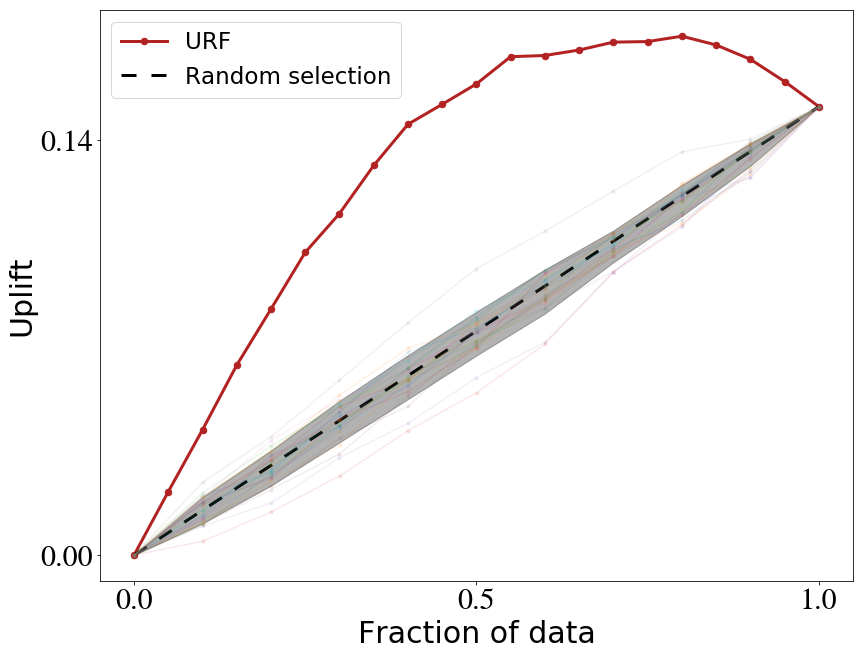

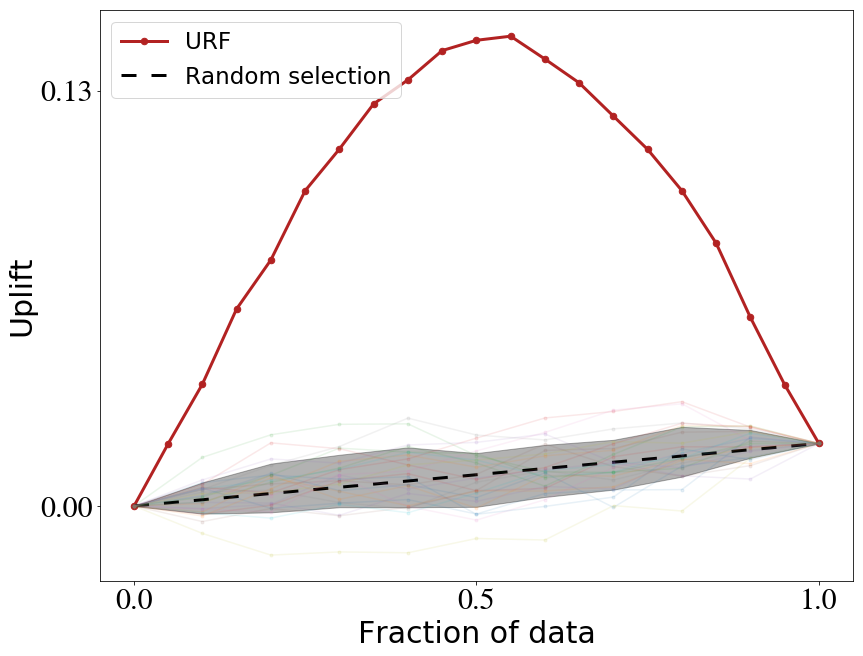

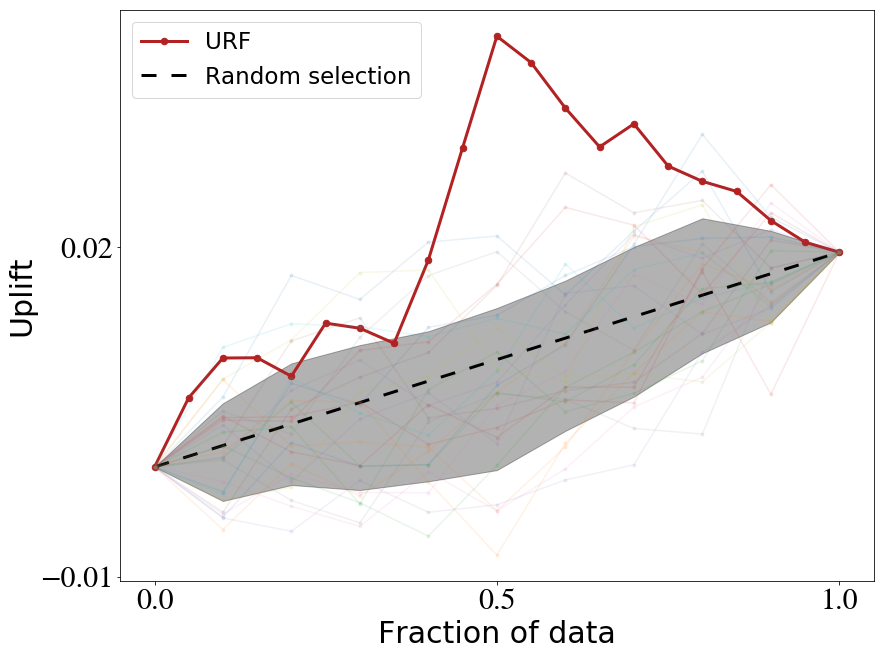

In [25]:
ax1 = restyle(up_before.plot(show_noise_fits=True,label="URF", color='firebrick', markersize=13, linewidth=3), [0, .14])
ax2 = restyle(up_after.plot(show_noise_fits=True,label="URF", color='firebrick', markersize=13, linewidth=3), [0, .13])
ax3 = restyle(up_across.plot(show_noise_fits=True,label="URF", color='firebrick', markersize=13, linewidth=3), [-.01, .02])

In [ ]:
axxb1 = restyle(up_before_xgb.plot(show_noise_fits=True,label="XGB", color='mediumvioletred', markersize=13, linewidth=3), [0, 0.1])
axxb2 = restyle(up_after_xgb.plot(show_noise_fits=True,label="XGB", color='mediumvioletred', markersize=13, linewidth=3), [-.01, .04])
axxb3 = restyle(up_across_xgb.plot(show_noise_fits=True,label="XGB", color='mediumvioletred', markersize=13, linewidth=3), [-.01, .03])